In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from ta.trend import EMAIndicator
from ta.momentum import RSIIndicator
from ta.volume import OnBalanceVolumeIndicator
from ta.volatility import BollingerBands
from sklearn.model_selection import train_test_split


# para esse modelo primeiramente eu declarei todas os meus métodos/funções, para no final fazer a chamada deles com os argumentos necessários

# Primeiro método
# Carregar os dados da API Yahoo Finance, também fiz um tratamento para formatar o Multiindex retornado da API para Dataframe
def carregar_dados_ativo(ticker, period, interval):
    try:
        dados = yf.download(ticker, period=period, interval=interval)
        if isinstance(dados.columns, pd.MultiIndex):
            dados.columns = [' '.join(col).strip() for col in dados.columns]
        colunas_esperadas = [f'{col} {ticker}' for col in ['Open', 'High', 'Low', 'Close', 'Volume']]
        if not set(colunas_esperadas).issubset(dados.columns):
            raise ValueError('Colunas esperadas não estão nos dados baixados')
        dados = dados[colunas_esperadas]
        dados.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
        dados = dados.astype(float)
        return dados
    except Exception as e:
        print(f'Erro ao baixar os dados: {e}')
        raise

# Segundo método
# plotar a matriz de correlação das dimensões dos dados
def exibir_matriz_correlacao(dados):
    plt.figure(figsize=(10, 6))
    sns.heatmap(dados.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Matriz de Correlação")
    plt.show()


# Terceiro método
# preparando os dados para leitura do modelo, isso é transformar os dados em números escaláveis e salva-los em um array multidimensional,
# dessa maneira podemos inverter a escala depois para mostrar em um gráfico
def preparar_dados_candles(dados, lookback, target_cols): # Lookback é a fatia de tempo que o modelo vai usar para o treinamento, cada unidade é uma linha no dataframe
    scaler_features = StandardScaler()
    scaler_targets = StandardScaler()

    features = dados.drop(columns=target_cols)
    targets = dados[target_cols]

    dados_features_normalizados = scaler_features.fit_transform(features)
    dados_targets_normalizados = scaler_targets.fit_transform(targets)

    X, y = [], []
    for i in range(lookback, len(dados_features_normalizados)):
        X.append(dados_features_normalizados[i-lookback:i, :])
        y.append(dados_targets_normalizados[i, :])

    return np.array(X), np.array(y), scaler_features, scaler_targets

# Quarto método
# gerando o modelo com alguns parâmetros de ajuste
def criar_modelo_lstm(input_shape, output_size):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(units=128, return_sequences=True),
        Dropout(0.2), #Dropout serve para deletar uma % de dados durante o treino para evitar sobrecarga, 0,2 = 20%
        LSTM(units=64, return_sequences=False),
        Dropout(0.2),
        Dense(units=32, activation='relu'), #
        Dense(units=output_size)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error') # Usa o atimizador que ajusta os pesos e mse como função de perda
    return model


In [ ]:
# agora vamos começar com a chamada dos métodos gerados
ticker = "BTC-USD"
period = "60d"
interval = "15m"
lookback = 240
target_cols = ['Close', 'High', 'Low', 'Open']

dados = carregar_dados_ativo(ticker, period=period, interval=interval)
dados.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Datetime,,,,,
2025-02-01 00:00:00+00:00,102405.390625,102522.515625,102304.156250,102522.515625,71462912.0
2025-02-01 00:15:00+00:00,102524.601562,102541.281250,102253.101562,102253.101562,0.0
2025-02-01 00:30:00+00:00,102249.765625,102479.570312,102249.765625,102428.015625,12607488.0
2025-02-01 00:45:00+00:00,102432.320312,102482.703125,102386.257812,102466.007812,47374336.0
2025-02-01 01:00:00+00:00,102462.703125,102577.664062,102455.304688,102577.664062,41566208.0


In [ ]:
# adicionando alguns indicadores básicos de trade no dataframe de dados, incrementando a oferta de features
dados['media curta'] = EMAIndicator(close=dados['Close'], window=3).ema_indicator()
dados['media longa'] = EMAIndicator(close=dados['Close'], window=9).ema_indicator()
dados['RSI'] = RSIIndicator(close=dados['Close'], window=14).rsi()
dados['On balance volume'] = OnBalanceVolumeIndicator(close=dados['Close'], volume=dados['Volume']).on_balance_volume()
bollinger = BollingerBands(close=dados['Close'], window=20, window_dev=2)
dados['bollinger_upper'] = bollinger.bollinger_hband()
dados['bollinger_lower'] = bollinger.bollinger_lband()
dados['bollinger_middle'] = bollinger.bollinger_mavg()
dados.head(100)

,Open,High,Low,Close,Volume,media curta,media longa,RSI,On balance volume,bollinger_upper,bollinger_lower,bollinger_middle
Datetime,,,,,,,,,,,,
2025-02-01 00:00:00+00:00,102405.390625,102522.515625,102304.156250,102522.515625,71462912.0,NaN,NaN,NaN,71462912.0,NaN,NaN,NaN
2025-02-01 00:15:00+00:00,102524.601562,102541.281250,102253.101562,102253.101562,0.0,NaN,NaN,NaN,71462912.0,NaN,NaN,NaN
2025-02-01 00:30:00+00:00,102249.765625,102479.570312,102249.765625,102428.015625,12607488.0,102407.912109,NaN,NaN,84070400.0,NaN,NaN,NaN
2025-02-01 00:45:00+00:00,102432.320312,102482.703125,102386.257812,102466.007812,47374336.0,102436.959961,NaN,NaN,131444736.0,NaN,NaN,NaN
2025-02-01 01:00:00+00:00,102462.703125,102577.664062,102455.304688,102577.664062,41566208.0,102507.312012,NaN,NaN,173010944.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-01 23:45:00+00:00,100727.015625,100802.203125,100614.585938,100644.203125,130975744.0,100621.951602,100768.191479,33.529945,-379547648.0,102045.650323,100268.490302,101157.070312
2025-02-02 00:00:00+00:00,100624.898438,100826.648438,100506.703125,100826.648438,143144960.0,100724.300020,100779.882871,39.646827,-236402688.0,101926.636100,100277.274057,101101.955078
2025-02-02 00:15:00+00:00,100834.101562,101105.921875,100810.664062,101105.921875,54710272.0,100915.110947,100845.090671,47.596447,-181692416.0,101828.422721,100306.500716,101067.461719


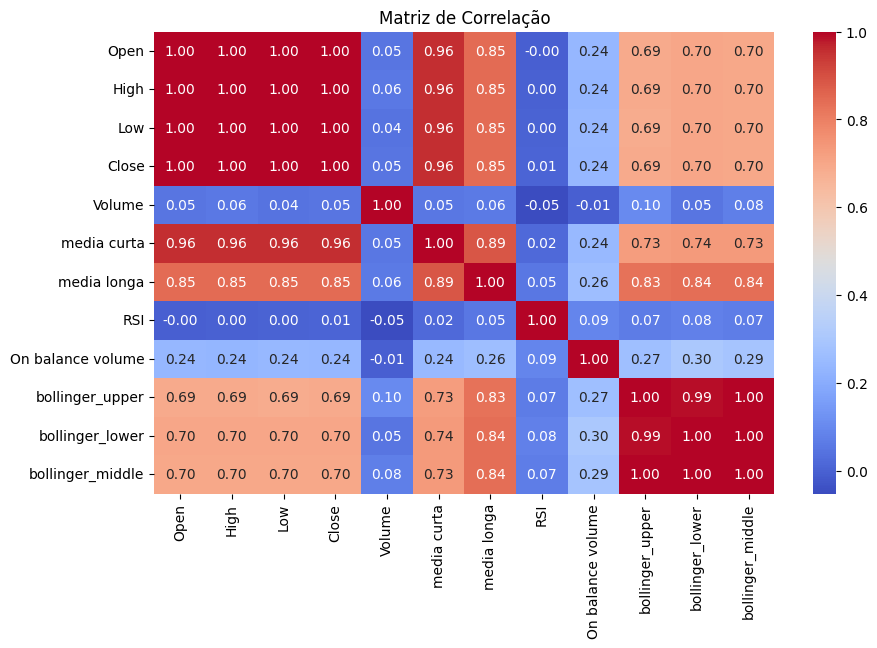

In [ ]:
# preechendo nulos nulos
dados = dados.fillna(0)
dados.head()
exibir_matriz_correlacao(dados)

In [28]:
# fazendo a chamada das funções, primeiro é o escalador que vai retornar as variaveis escaladas e as originais
X, y, scaler_features, scaler_targets = preparar_dados_candles(dados, lookback, target_cols)
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, shuffle=False)

# definindo o modelo
modelo = criar_modelo_lstm((X.shape[1], X.shape[2]), len(target_cols))

# opcionalemte usamos a instância EarlyStooping que interrompe o treinamento em caso de detecção de overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

historico = modelo.fit(X_treino, y_treino, epochs=100, batch_size=32,
                       validation_data=(X_teste, y_teste),
                       callbacks=[early_stopping], verbose=0)

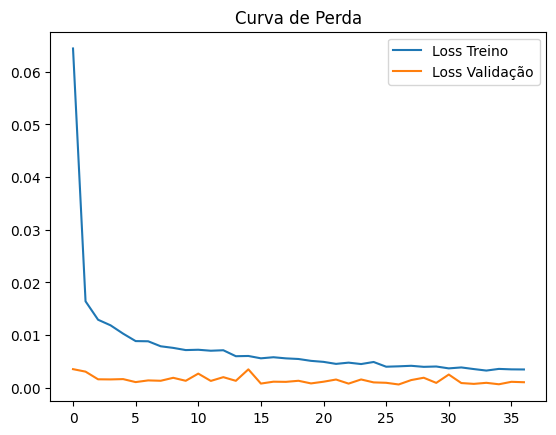

In [29]:
# mostrar o histórico com a variação das métricas de EarlyStopping
plt.plot(historico.history['loss'], label='Loss Treino')
plt.plot(historico.history['val_loss'], label='Loss Validação')
plt.legend()
plt.title('Curva de Perda')
plt.show()


In [30]:
# escalonando os dados do dataframe original a normalidade, foram alterados no método 'preparar_dados_candles'
y_teste_real = scaler_targets.inverse_transform(y_teste)
y_pred_real = scaler_targets.inverse_transform(modelo.predict(X_teste))


35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 299ms/step


In [31]:
# subtituindo valores NaN gerados por zero, sem remover a linha por completo
y_teste_real_clean = np.nan_to_num(y_teste_real, nan=0)
y_pred_real_clean = np.nan_to_num(y_pred_real, nan=0)

mae = mean_absolute_error(y_teste_real_clean, y_pred_real_clean)
rmse = np.sqrt(mean_squared_error(y_teste_real_clean, y_pred_real_clean))
r2 = r2_score(y_teste_real_clean, y_pred_real_clean)

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R²: {r2:.2f}')

MAE: 121.10
RMSE: 160.64
R²: 0.99


In [39]:
# nesse loop estou dividindo a previsão das próximas 24 horas em intervalos de 15 minutos, resultando em um laço de 96 periodos.
# para cada periodo eu salvo o candle anterior com a variável 'ultimo_candle' para ir montando a previsão até o fim do loop
# no final salvo a previsão das 24h em um outro dataframe
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Oculta avisos e infos do TensorFlow
import tensorflow as tf
tf.get_logger().setLevel('ERROR')  # Oculta logs adicionais do TensorFlow

previsoes_futuras = []
ultimo_candle = X_teste[-1:].copy()

for _ in range(96):
    previsao_normalizada = modelo.predict(ultimo_candle)
    previsao_real = scaler_targets.inverse_transform(previsao_normalizada)
    previsoes_futuras.append(previsao_real[0])

    novo_candle = np.roll(ultimo_candle, shift=-1, axis=1)
    novo_candle[0, -1, :len(target_cols)] = previsao_normalizada[0]
    ultimo_candle = novo_candle

previsoes_futuras = np.array(previsoes_futuras)

# em novo_datetime gero a periodicidade que servirá como eixo X no gráfico de candles final
novo_datetime = pd.date_range(start=dados.index[-1] + pd.Timedelta(minutes=15), periods=96, freq='15T')
dados_candles_previsoes = pd.DataFrame(previsoes_futuras, columns=target_cols, index=novo_datetime)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10

<ipython-input-39-8135ab73dcd3>:24: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  novo_datetime = pd.date_range(start=dados.index[-1] + pd.Timedelta(minutes=15), periods=96, freq='15T')


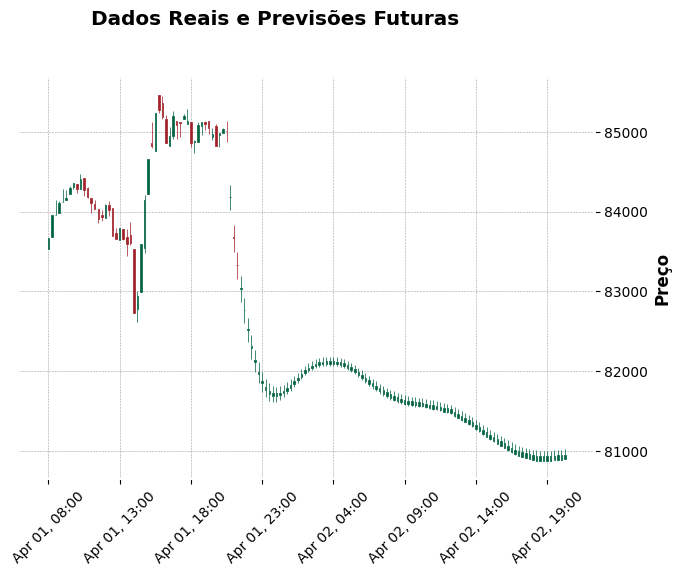

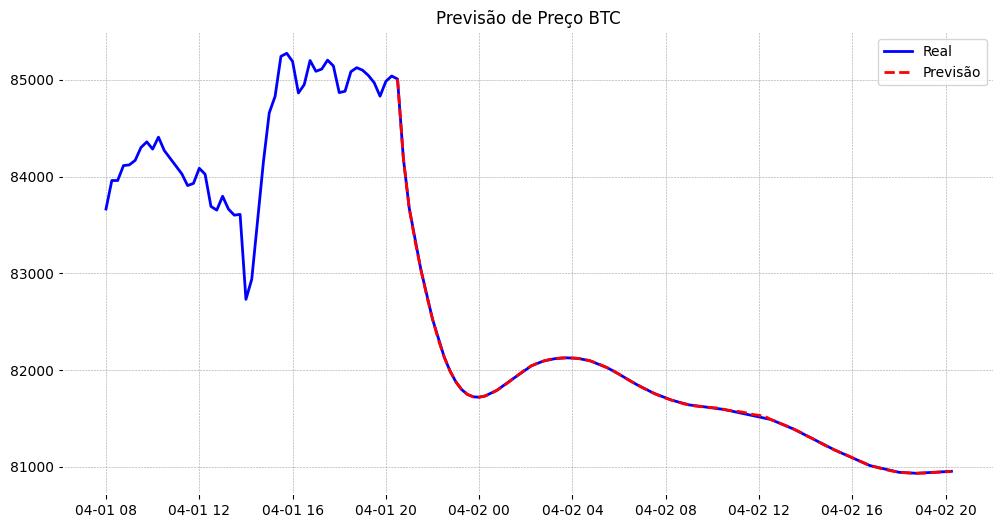

In [40]:
dados_plot = dados[['Open', 'High', 'Low', 'Close']].copy().iloc[-50:]
dados_plot = pd.concat([dados_plot, dados_candles_previsoes])

fig, ax = mpf.plot(dados_plot, type='candle', style='charles', title='Dados Reais e Previsões Futuras', ylabel='Preço', volume=False, returnfig=True)
plt.show()

# CONCLUSÃO DO EXPERIMENTO
# embora todas as etapas tenham sido feitas conforme terminologia padrão dos estudos de machine learning, o gráfico de previsão não apresenta boa coerência com os candles reais,
# uma alternativa viável será substituir candles por somente linha, visto que dados de abertura e fechamento impactam diretamente na formação de candles, para análise gráfica é pouco específico mas
# para uma previsão focada somente em variação do preço é uma alternativa viável
plt.figure(figsize=(12, 6))
plt.plot(dados_plot.index, dados_plot['Close'], label='Real', color='blue')
plt.plot(dados_candles_previsoes.index, dados_candles_previsoes['Close'], label='Previsão', linestyle='dashed', color='red')
plt.legend()
plt.title('Previsão de Preço BTC')
plt.show()
